Load library

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import json

# Load the labeled dataset
df = pd.read_csv('labeled_donor_data.csv')

/Users/muhdsafrul/Desktop/Dev/Repositories/MuamalatGo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df["Fraud Label (Rule-Based)"] = df["Fraud Label (Rule-Based)"].replace({"Not Fraud": 0, "Fraud": 1})
df["Fraud Label (Rule-Based)"].value_counts()

/var/folders/mx/y17kcnqx7px80lzr6fncvzn80000gn/T/ipykernel_58705/931101798.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Fraud Label (Rule-Based)"] = df["Fraud Label (Rule-Based)"].replace({"Not Fraud": 0, "Fraud": 1})


Fraud Label (Rule-Based)
0    12346
1     2654
Name: count, dtype: int64

Just to verify

In [3]:
data_types = df.dtypes.tolist()
columns = df.columns.tolist()
for column, dtype in zip(columns, data_types):
    print(f"{column}: {dtype}")

Nama Pemohon/Institusi: object
Emel: object
No. K/P (baru)/Polis/Tentera/No. Pasport: object
No. Telefon Bimbit: object
Declared Income: float64
Savings: float64
Investment (Stocks/Bonds): float64
Gold (grams): int64
Property (number): int64
Profession: object
Location: object
Donation Frequency: int64
Average Donation Amount: float64
Fraud Label (Rule-Based): int64


Training Pipeline + Explaining with SHAP

/Users/muhdsafrul/Desktop/Dev/Repositories/MuamalatGo/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:57:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


There are 6 categorical cols and 7 numerical cols
Confusion Matrix:
[[2412   57]
 [ 139  392]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2469
           1       0.87      0.74      0.80       531

    accuracy                           0.93      3000
   macro avg       0.91      0.86      0.88      3000
weighted avg       0.93      0.93      0.93      3000

Generating SHAP summary plot...


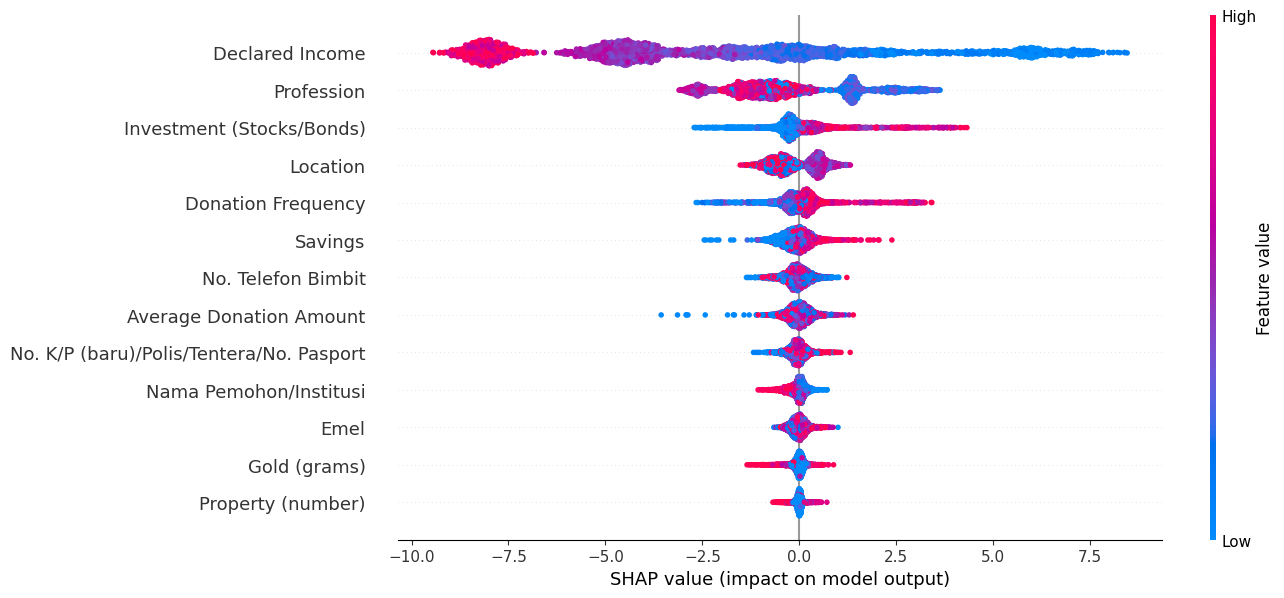

Waterfall plot for test sample index 0:


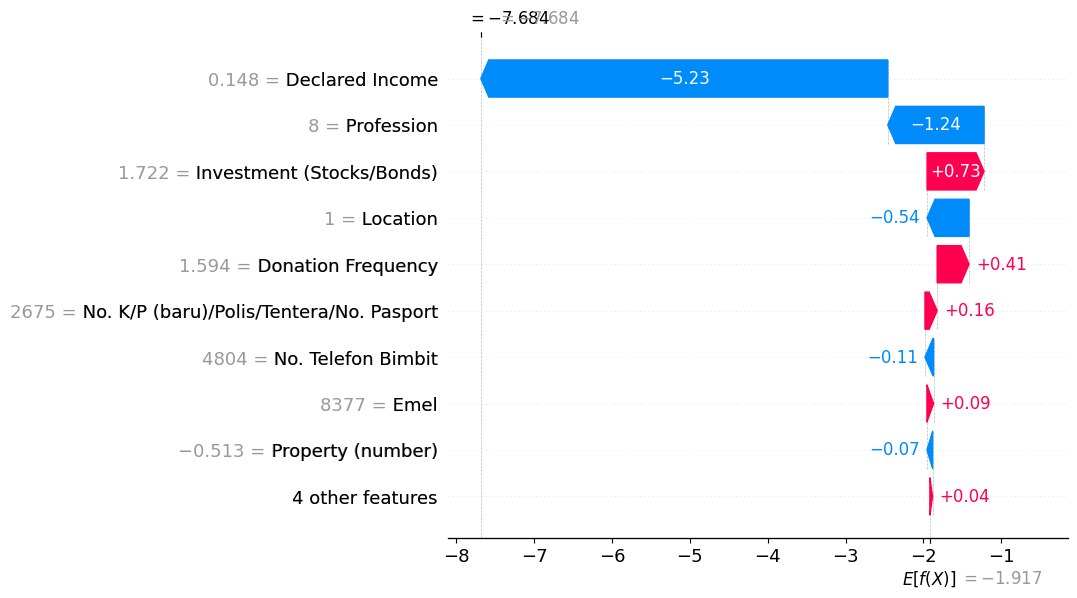

In [4]:
# Separate categorical columns
cat_cols = df.select_dtypes(include='object').columns

# Separate numerical columns, excluding 'is_fraud'
num_cols = df.select_dtypes(include='number').columns.difference(['Fraud Label (Rule-Based)'])

# Fill missing values
df[cat_cols] = df[cat_cols].fillna('Unknown')
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

print(f"There are {len(cat_cols)} categorical cols and {len(num_cols)} numerical cols")

# Encode categorical features
encoder = OrdinalEncoder()
df[cat_cols] = encoder.fit_transform(df[cat_cols])

# Define features (excluding the target variable) and target
X = df.drop(columns=['Fraud Label (Rule-Based)'])  # Drop the target variable
y = df['Fraud Label (Rule-Based)']  # Target remains unchanged

# Scale numerical data (only features, not labels)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])  # Scale only numerical features

# Step 2: Split the preprocessed features (X) into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Build XGBoost classifier directly
pipeline = Pipeline(steps=[
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# Step 4: Fit XGBoost model
pipeline.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Print the evaluation results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 6: Explain model predictions using SHAP
def explain_with_shap(pipeline, test_data, sample_index=0):
    model = pipeline.named_steps['classifier']

    # Use TreeExplainer directly for XGBoost
    explainer = shap.Explainer(model)
    shap_values = explainer(test_data)

    fig = plt.figure()

    # SHAP Summary Plot
    print("Generating SHAP summary plot...")
    shap.summary_plot(shap_values, features=test_data, feature_names=test_data.columns, show=False)

    plt.gcf().set_size_inches(20,6)
    plt.show()

    # SHAP Waterfall Plot for one instance
    print(f"Waterfall plot for test sample index {sample_index}:")
    shap.plots.waterfall(shap_values[sample_index])

# Call the SHAP explanation function
explain_with_shap(
    pipeline,
    test_data=X_test,
    sample_index=0
)
